# Change point detection methods for rearing detection

1. Organize the design matrix for change point detection
2. change point detection

# 1. Load the data

# 

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from base import MultiDaysBeaconPosition, BeaconPosition
from scipy.stats import sem
from utils.basic_utils import get_tags, calculate_cumulative_distribution
from sklearn.decomposition import PCA

from utils.baseline_method import continuous_detection 

In [2]:
root_path = '../Data/Raw/'
rat_id = 'FS10'
rat_subdirectories = glob(root_path+rat_id+'/*/' )

tags = get_tags(rat_subdirectories)

## 1.1 For one tag of rat

In [422]:
tag_id = 1
this_tag = BeaconPosition(rat_subdirectories[tag_id], tags[tag_id], True, True) #position data of this tag

In [423]:
unit_time = np.mean(this_tag.position_data[1:,0] - this_tag.position_data[:-1,0])
print(unit_time) # average time for a bin

0.01664969156007157


# 2. get matrix

In [424]:
# set the parameters
save_fig = False # whether save the fig for the results

T = 200
tau = 10
group_step = 10 # so that no overlap between taus

height_thresh = 0.6 # threshold for height/z to determine rearing

# get some important variables
xy_speed = np.insert(this_tag.speed,0,0) # speed on xy planar insert 0 at the beginning of the speed array to make the size same
z_speed = np.divide(this_tag.position_data[1:,3] - this_tag.position_data[:-1,3], this_tag.position_data[1:,0] - this_tag.position_data[:-1,0])
z_speed = np.insert(z_speed,0,0) # insert 0 at the beginning of the speed array to make the size same 

z = this_tag.position_data[:,3]

# organize k features that we're interested in
k = 4
all_feature_matrix = np.zeros((k, len(z)))
all_feature_matrix[0,:] = z
all_feature_matrix[1,:] = this_tag.position_data[:,6] # pitch
all_feature_matrix[2,:] = z_speed
all_feature_matrix[3,:] = xy_speed

In [158]:
len(z)

108578

In [6]:
def rearing_detection(z, height_thresh = 0.6):
    '''
    detect rearing by the height_thresh, if z[i]> = height_thresh, then the time of z[i] if rearing time
    z: array of height in time series
    height_thresh :threshold to determine the rearing
    
    return:
    r: array of index of rearing time
    '''
    
    return np.argwhere(z>= height_thresh).flatten()
    

In [19]:
def generate_tau_sample(before_matrix, tau = 10, step = 2, T = 200):
    '''
    generate a matrix of tau length sample by slicing the window along the whole time series
    features: [n,k,T]
    
    return : array in[n*m, tau*k], m is the number of slice of tau for T long period
    '''
    # determine the size of the final output
    
    # use a time window to slip along T and get slice of tau, combine different features horizontally, 

    num_slice = T//tau # step = tau, no overlap
    num_events = before_matrix.shape[0]
    x_matrix = np.zeros((num_events * num_slice, tau * k))


    step = tau
    for i, end_idx in enumerate(np.arange(tau, T+1, step)):
        x_matrix[i*num_events: (i+1)*num_events, :] = np.hstack(np.transpose(before_matrix[:,:,end_idx - tau:end_idx],(1,0,2))) 
    
    
    return x_matrix

In [425]:
rearing_idx = rearing_detection(z, height_thresh= height_thresh)
whether_continue, rearing_periods = continuous_detection(rearing_idx, discontinu_tolerance= 10, total_tolerance= 20,seperate= True)

# rearing_periods: slice of different rearing events

In [426]:
# for each rearing event, get T length time before it
before_list = []
for i,this_rearing in enumerate(rearing_periods):
    begin_idx = this_rearing[0]
    if begin_idx - T >=0:
        before_list.append(all_feature_matrix[:,begin_idx - T: begin_idx])
before_matrix = np.asarray(before_list) # in shape [num_event, k, T]
num_events = before_matrix.shape[0]

# 3. Visualize data (heatmap)

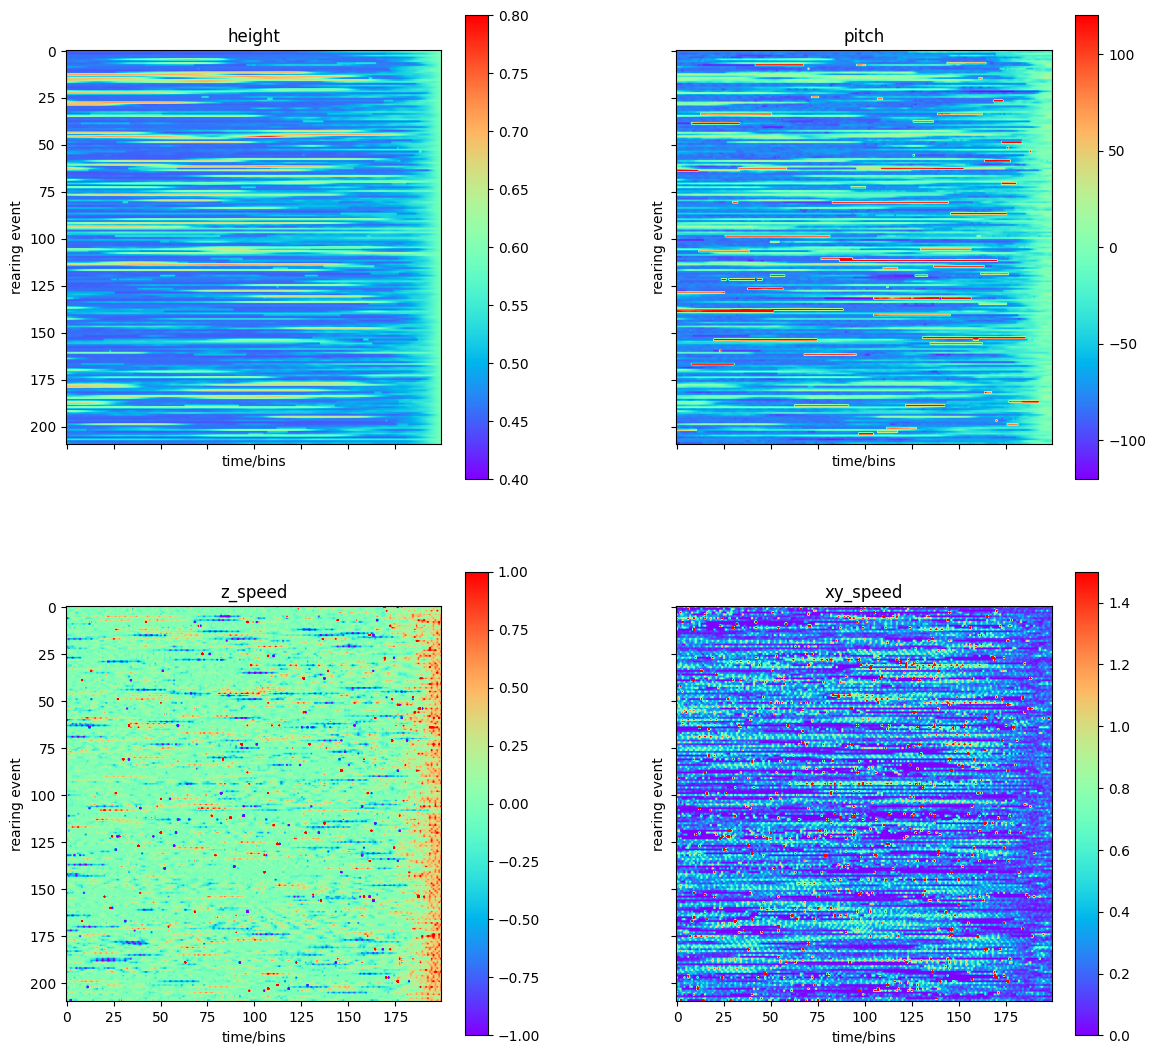

In [427]:
feature_labels = ['height', 'pitch','z_speed', 'xy_speed']
fig, axis = plt.subplots(2,2, figsize = (12,12), sharey = True, sharex = True)
axis = axis.flatten()
vmaxs = [0.8,120,1,1.5]
vmins = [0.4,-120,-1,0]


fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
                    hspace=0.2, wspace=0.3)
for i, label in enumerate(feature_labels):
    this_matrix = before_matrix[:,i,:]
    heatmap = axis[i].imshow(this_matrix, cmap = 'rainbow',vmax = vmaxs[i], vmin = vmins[i])
    axis[i].set_xlabel('time/bins')
    axis[i].set_ylabel('rearing event')
    # axis[i].set_ystick()
    axis[i].set_title(label)
    fig.colorbar(heatmap, ax =axis[i])
    
    # axis[i].imshow(change_matrix, )

# 4. Cumulative disdribution for bins before rearing threshold

In [428]:
blue_colors = plt.cm.Blues(np.linspace(0.3, 1, 20))
red_colors = plt.cm.Reds(np.linspace(0.3, 1, 20))
color_sets = [element for lis in [red_colors, blue_colors ] for element in lis]
color_sets_2 = [element for lis in [blue_colors,red_colors ] for element in lis]

In [429]:
tau = 5

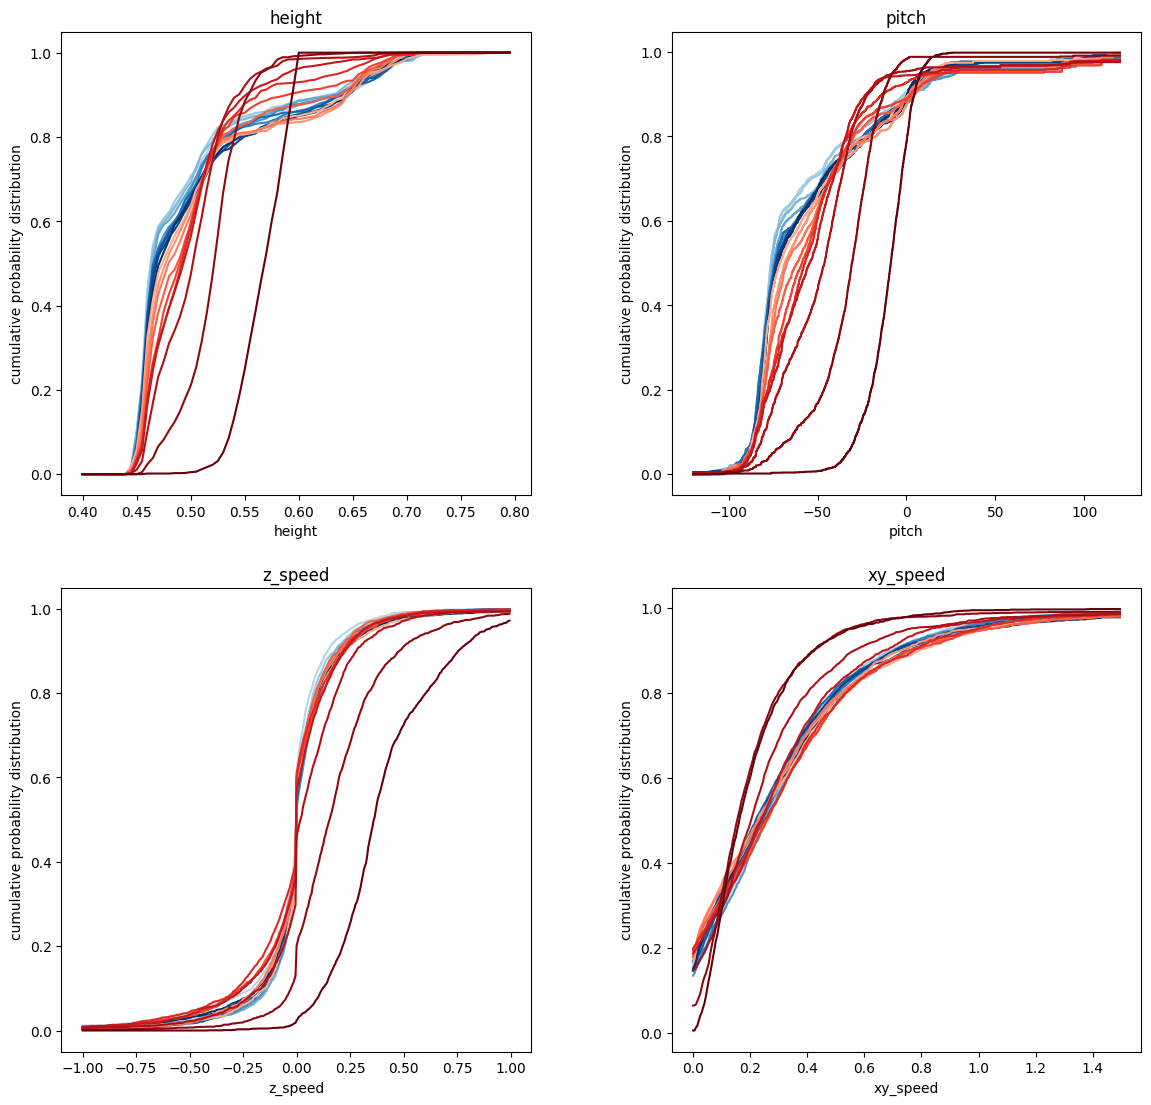

In [438]:
feature_labels = ['height', 'pitch','z_speed', 'xy_speed']
fig, axis = plt.subplots(2,2, figsize = (12,12))
axis = axis.flatten()
vmaxs = [0.8,120,1,1.5]
vmins = [0.4,-120,-1,0]


fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
                    hspace=0.2, wspace=0.3)
for i, label in enumerate(feature_labels):
    this_matrix = before_matrix[:,i,:]
    for j,bin_idx in enumerate(np.arange(0,T,tau)):
        x, this_cpd = calculate_cumulative_distribution(this_matrix[:,bin_idx:bin_idx+tau].flatten(), step = 0.005, set_max=True, set_min= True, max_x=vmaxs[i], min_x=vmins[i])
        axis[i].plot(x, this_cpd, label = bin_idx - T ,color = color_sets_2[j])
        axis[i].set_xlabel(feature_labels[i])
        axis[i].set_ylabel('cumulative probability distribution')
        axis[i].set_title(label)
        # axis[i].legend()


# 5. Change point detection

In [431]:
def density_function(x, step = 0.005,set_max = False, max_x = 1, set_min = False, min_x = -1):
    '''
    calculate the density of given x
    x: array
    step: step to calculate functions 
    '''
    sorted_x = np.sort(x)
    
    if set_max == False:
        max_x =  sorted_x[-1]
        
    if set_min == False:
        min_x = sorted_x[0]
    
    line_x = np.arange(min_x, max_x, step)
    density = []
    for i in np.arange(min_x, max_x, step):
        
        density.append(np.count_nonzero((i<=sorted_x) & (sorted_x<i+step)))
    
    return line_x, np.asarray(density)/len(x) # get the probability


def KL(a, b):
    '''
    calculate the KL divergence between two distribution
    '''
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    
    for i, value in enumerate(b):
        if value ==0:
            b[i] = np.exp(-6) # incase b = 0
    return np.sum(np.where(a != 0, a * np.log(np.round(a/b,10)), 0))


In [432]:
def kl_change_point_detection(feature_matrix, gama = 1, tau = 5, feature_step= 0.02,max_x = 0.8, min_x = 0.5):
    # calculate the difference of density function to find the breaking point

    break_point = []
    change_matrix = np.zeros_like(feature_matrix)
    kl_matrix = []

    for which_event in range(0,feature_matrix.shape[0]):
        this_feature = feature_matrix[which_event,:]
        x,pre_p = density_function(this_feature[0:tau],set_max = True, max_x = max_x, set_min = True, min_x = min_x,step = feature_step)

        all_kl = []
        mean_kls = []
        
        for begin_idx in np.arange(tau,T,tau):
            x,this_p = density_function(this_feature[begin_idx:begin_idx+tau], set_max = True, max_x = max_x, set_min = True, min_x = min_x,step = feature_step)
            this_kl = max(KL(pre_p, this_p), KL(this_p, pre_p)) 
            
            pre_p = this_p
            all_kl.append(this_kl)
            mean_kl = np.mean(all_kl)
            mean_kls.append(mean_kl)
            if this_kl> gama* mean_kl:
                break_point.append(begin_idx)
                
                change_matrix[which_event, begin_idx: begin_idx+tau] = 1

        kl_matrix.append(all_kl)


    kl_matrix = np.asarray(kl_matrix)  

    return kl_matrix, change_matrix
    

In [435]:
tau = 10

blue_colors = plt.cm.Blues(np.linspace(0.3, 1, int(T/2//tau)))
red_colors = plt.cm.Reds(np.linspace(0.3, 1, int(T/2//tau)))
color_sets = [element for lis in [red_colors, blue_colors ] for element in lis]
color_sets_2 = [element for lis in [blue_colors,red_colors ] for element in lis]

/var/folders/rm/m418549n60ldjvfgbchrnp8r0000gn/T/ipykernel_25032/1637647520.py:32: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(np.round(a/b,10)), 0))
/var/folders/rm/m418549n60ldjvfgbchrnp8r0000gn/T/ipykernel_25032/1637647520.py:32: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(np.round(a/b,10)), 0))


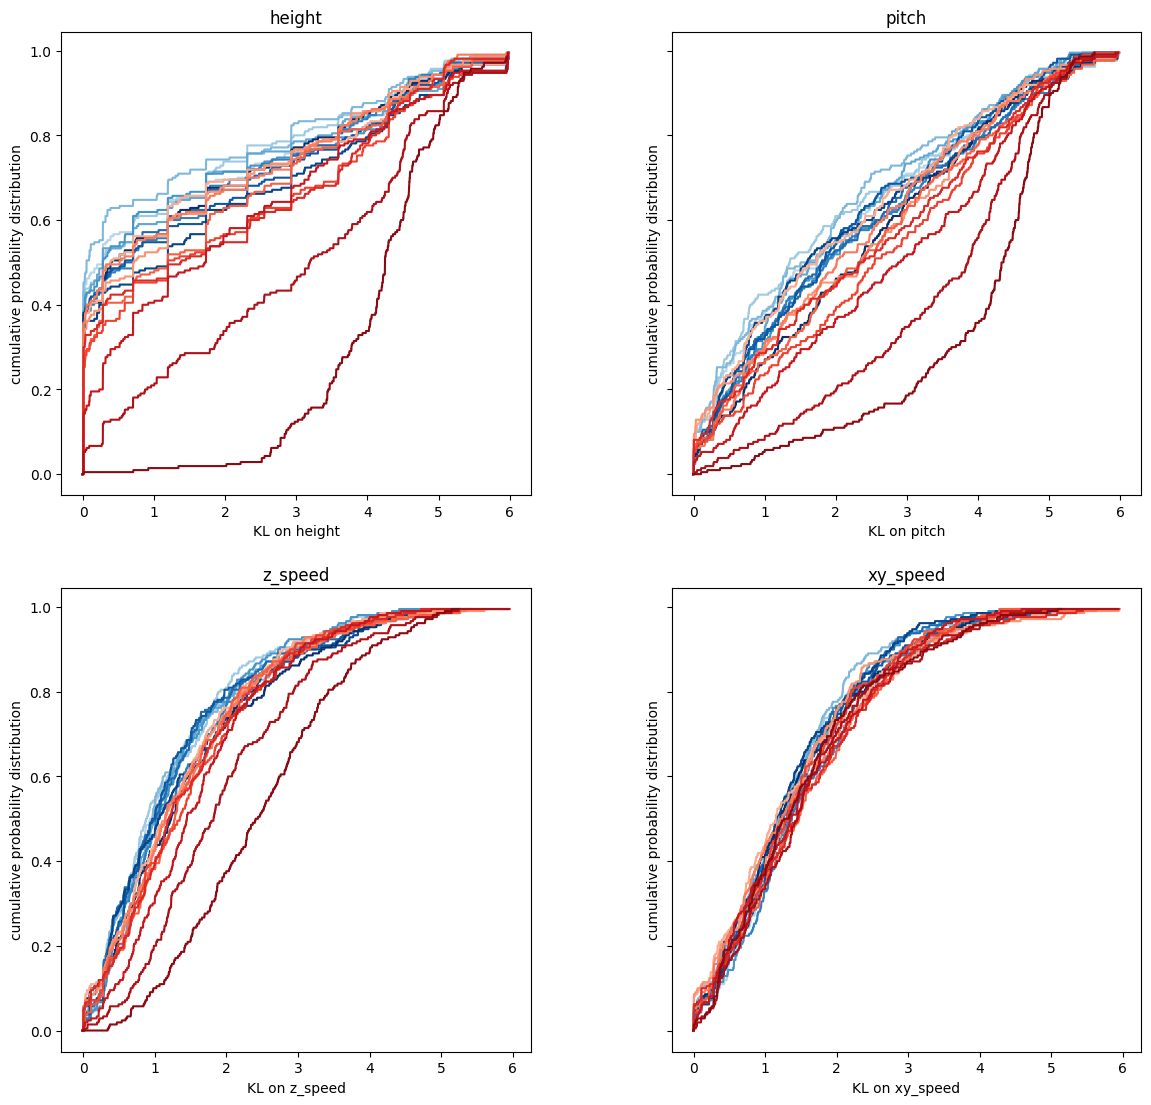

In [436]:
feature_labels = ['height', 'pitch','z_speed', 'xy_speed']
fig, axis = plt.subplots(2,2, figsize = (12,12),sharey= True)
axis = axis.flatten()
vmaxs = [0.8,120,1,1.5]
vmins = [0.4,-120,-1,0]
tau = 10
feature_steps = [0.02, 5, 0.1,0.1]

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
                    hspace=0.2, wspace=0.3)
for i, label in enumerate(feature_labels):
    this_matrix = before_matrix[:,i,:]
    this_kl, this_change_matrix = kl_change_point_detection(this_matrix, gama = 4, tau = tau, feature_step=feature_steps[i],max_x = vmaxs[i], min_x=vmins[i])
    for j,bin_idx in enumerate(np.arange(0,T-tau,tau)):
        x, this_cpd = calculate_cumulative_distribution(this_kl[:,j].flatten(), step = 0.001, set_max=False, set_min= True, max_x=vmaxs[i], min_x=-0.01)
        axis[i].plot(x, this_cpd, label = bin_idx - T ,color = color_sets_2[j])
        axis[i].set_xlabel('KL on %s'%feature_labels[i])
        axis[i].set_ylabel('cumulative probability distribution')
        axis[i].set_title(label)
        # axis[i].legend()

In [418]:
this_cpd

array([0.34224599, 0.34224599, 0.34224599, ..., 0.96791444, 0.96791444,
       0.96791444])

In [ ]:
# calculate the difference of density function to find the breaking point

tau = 5
break_point = []
change_matrix = np.zeros_like(before_matrix[:,0,:])
kl_matrix = []
which_feature = 0

feature_step = 0.02

# for height
for which_event in range(0,before_matrix.shape[0]):
    this_feature = before_matrix[which_event,which_feature,:]
    x,pre_p = density_function(this_feature[0:tau],set_max = True, max_x = vmaxs[which_feature], set_min = True, min_x = vmins[which_feature],step = feature_step)
    gama = 4
    all_kl = []
    mean_kls = []
    # print('event %d'%which_event)
    for begin_idx in np.arange(tau,T,tau):
        x,this_p = density_function(this_feature[begin_idx:begin_idx+tau],set_max = True, max_x = vmaxs[which_feature], set_min = True, min_x = vmins[which_feature], step = feature_step)
        this_kl = max(KL(pre_p, this_p), KL(this_p, pre_p)) 
        
        pre_p = this_p
        all_kl.append(this_kl)
        mean_kl = np.mean(all_kl)
        mean_kls.append(mean_kl)
        if this_kl> gama* mean_kl:
            break_point.append(begin_idx)
            
            change_matrix[which_event, begin_idx: begin_idx+tau] = 1

    kl_matrix.append(all_kl)


kl_matrix = np.asarray(kl_matrix)  
plt.imshow(kl_matrix)
            
# change_matrix[change_matrix==0] = np.nan # nan to 0 
# plt.imshow(change_matrix)
    
# # plt.plot(np.arange(0,20,0.1),this_feature)
# plt.plot(np.asarray(all_kl))
# plt.plot(gama*np.asarray(mean_kls))
    